In [1]:
import time
import torch
import sys
sys.path.append('../Research Paper/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from PIL import Image

from torchvision.transforms import Grayscale

from modules.train import load_prototypical_network_checkpoint, transform
from modules.data_utils import load_image


In [2]:
images_and_ids = pd.read_csv('../Research Paper/data/training_10samples.csv')
images_and_ids

,Image,Id,class_count
0,0000e88ab.jpg,w_f48451c,14
1,000a6daec.jpg,w_dd88965,16
2,001cae55b.jpg,w_581ba42,14
3,004e8ad5b.jpg,w_3de579a,54
4,004f87702.jpg,w_1d0830e,11
...,...,...,...
3569,ffad54783.jpg,w_f0fe284,45
3570,ffc0dd0dc.jpg,w_4a28f21,13
3571,ffcd5efdc.jpg,w_f765256,34
3572,ffe52d320.jpg,w_bc285a6,21


In [3]:
def get_sample_sets(df, n_way, n_shot):
    sample_support_labels = np.random.choice(df['Id'], size=n_way, replace=False)

    sample_support_set = {}
    for label in sample_support_labels:
        sample_support_set[label] = np.random.choice(df[df['Id'] == label]['Image'], size=n_shot, replace=False)

    sample_query_set = []
    for label, images in sample_support_set.items():
        filtered_images = df[
            (df['Id'] == label) &
            (~df['Image'].isin(images))
        ]['Image']
        sample_query_set += np.random.choice(filtered_images, size=1, replace=False).tolist()
    
    return sample_support_labels, sample_support_set, sample_query_set

### Get sample Support/Query Set

In [9]:
sample_support_labels, sample_support_set, sample_query_set = get_sample_sets(images_and_ids, 3, 3)

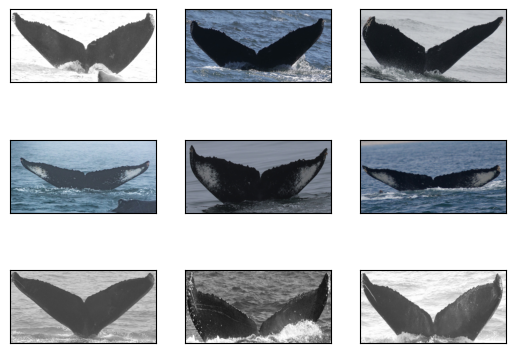

In [10]:
fig, axs = plt.subplots(3, 3)

for i, (label, images) in enumerate(sample_support_set.items()):
    for j, image in enumerate(images):
        img = Image.open(f'/workspaces/creating-ai-enabled-systems/Research Paper/data/train/{image}')
        img = img.resize((512, 256))

        axs[i,j].imshow(img)

        axs[i,j].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

fig.savefig('sample_support_set.png', transparent=True)

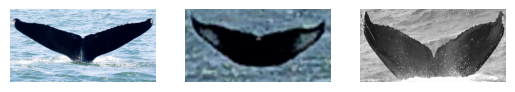

In [11]:
fig, axs = plt.subplots(1, 3)

for i, image in enumerate(sample_query_set):
    img = Image.open(f'/workspaces/creating-ai-enabled-systems/Research Paper/data/train/{image}')
    img = img.resize((512, 256))

    axs[i].imshow(img)
    axs[i].axis('off')

fig.savefig('sample_query_set.png', transparent=True)

### Preprocess two example images

In [3]:
rectangle_image = Image.open('/workspaces/creating-ai-enabled-systems/Systems Project/images/rectangle-image.jpg')
square_image = Image.open('/workspaces/creating-ai-enabled-systems/Systems Project/images/square-image.jpg')

In [7]:
rectangle_image_resized = rectangle_image.resize((512, 256))
square_image_resized = square_image.resize((512, 256))

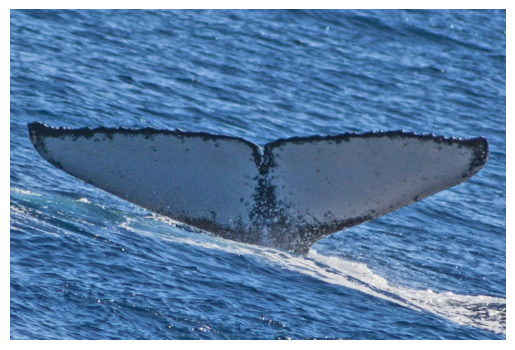

In [18]:
plt.imshow(square_image)
plt.axis('off');

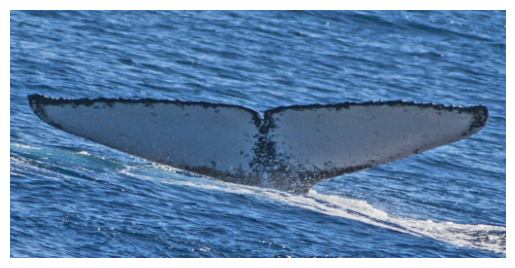

In [14]:
plt.imshow(square_image_resized)
plt.axis('off')
plt.savefig('images/square-image-resized.jpg',  transparent=True)

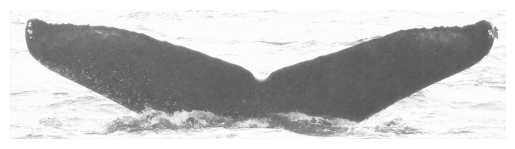

In [17]:
plt.imshow(rectangle_image)
plt.axis('off');
# plt.savefig('images/rectangle-image-resized.jpg', transparent=True)

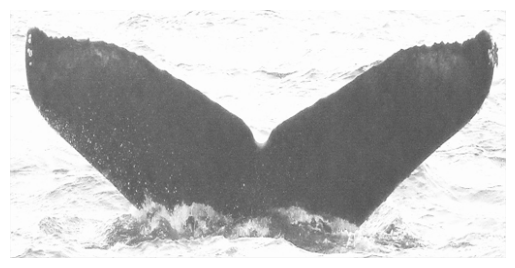

In [15]:
plt.imshow(rectangle_image_resized)
plt.axis('off')
plt.savefig('images/rectangle-image-resized.jpg', transparent=True)

### Analyze speed of Prototypical Model with different parameters

In [4]:
model = load_prototypical_network_checkpoint(
    savepath='/workspaces/creating-ai-enabled-systems/Systems Project/models/prototypical_network_5-way_5-shot_last_epoch',
    map_location=torch.device('cpu')
)
model = model.eval()

In [5]:
def load_images(image_filenames):
    images = []
    for image_fn in image_filenames:
        image, num_channels = load_image(image_fn)
        
        if num_channels != 3:
            image = Grayscale(num_output_channels=3)(image)
        image = transform(image)
        images += [np.asarray(image).tolist()]

    images = np.array(images)
    return images

In [6]:
n_ways  = [5, 10, 20]
n_shots = [3, 5]
time_dict = dict()
for n_way, n_shot in product(n_ways, n_shots):
    if n_way == 20 and n_shot == 5: continue
    if n_way not in time_dict: time_dict[n_way] = dict()
    _, support_set, query_set = get_sample_sets(images_and_ids, n_way, n_shot)
    support_idxs = [i for i, label in enumerate(support_set.keys()) for _ in range(len(support_set[label]))]

    support_images = []
    for label, image_filenames in support_set.items():
        support_images.extend(load_images(image_filenames))

    query_images = load_images(query_set)

    support_labels_tensor = torch.Tensor(support_idxs).float()
    support_images_tensor = torch.from_numpy(np.array(support_images)).float()
    query_images_tensor = torch.from_numpy(np.array(query_images)).float()

    start_time = time.time()
    model.process_support_set(support_images_tensor, support_labels_tensor)
    _ = model(query_images_tensor)
    end_time = time.time()

    diff = end_time - start_time

    print(f'{n_way}-way {n_shot}-shot took {diff:.3f} seconds')
    time_dict[n_way][n_shot] = diff

# Jupyter Kernel kept crashing after 10 seconds for 20-way 5-shot scenario, so we will cap the execution time to 10 seconds
time_dict[20][5] = 10.0


5-way 3-shot took 1.414 seconds
5-way 5-shot took 2.043 seconds
10-way 3-shot took 2.727 seconds
10-way 5-shot took 3.670 seconds
20-way 3-shot took 4.792 seconds


In [31]:
time_dict[5].items()

dict_items([(3, 1.4144349098205566), (5, 2.0433616638183594)])

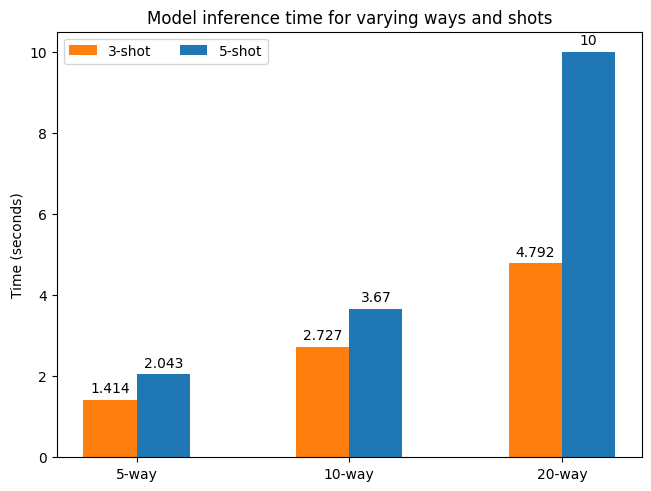

In [86]:
def plot_time_bars(times, colors, multiplier, ax, labels=None):
    offset = 0
    for n_shot, time in times.items():
        offset = width * multiplier
        label = labels[n_shot] if labels is not None else None
        rects = ax.bar(offset, round(time, 3), width, label=label, color=colors[n_shot])
        ax.bar_label(rects, padding=3)
        multiplier += 1

fig, ax = plt.subplots(layout='constrained')
colors = {3: 'tab:orange', 5: 'tab:blue'}
labels = {3: '3-shot', 5: '5-shot'}

multiplier = 0.5
for n_way in time_dict.keys():
    plot_time_bars(time_dict[n_way], colors, multiplier, ax, labels)
    multiplier += 4.0
    labels = None

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (seconds)')
ax.set_title('Model inference time for varying ways and shots')
ax.set_xticks(x + width, [f'{n}-way' for n in n_ways]);
ax.legend(loc='upper left', ncols=3)
